In [1]:
import matplotlib.pyplot as plt
from pickle_loader import pickle_loader
import datetime as dt
import pandas as pd
from random import seed
from random import randint
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [2]:
technical_data = pickle_loader('technical_us.pickle')

In [3]:
def tech_clean(dataset):
    clean_dataset = dataset.copy()
    tickers = list(technical_data.keys())
    removed_tickers = []
    
    for ticker in tickers:
        if len(dataset[ticker]) == 0: # Remove tickers that are empty 
            clean_dataset.pop(ticker, None)
            removed_tickers.append(ticker)
        else: # Remove tickers that don't contain the full dataset 
            first_time = dataset[ticker].index.to_pydatetime()[0].strftime('%d-%m-%Y')
            last_time = dataset[ticker].index.to_pydatetime()[-1].strftime('%d-%m-%Y')
            if first_time != '30-09-2021' or last_time != '29-09-2023':
                clean_dataset.pop(ticker, None)
                removed_tickers.append(ticker)
    
    return clean_dataset, removed_tickers 

In [4]:
clean_tech_data, removed_tickers = tech_clean(technical_data)

The close price is the price that is being modeled/pricted

The start of the train dataset is '2021-09-30 00:00:00-0400'.

The end of the train set is '2022-09-27 00:00:00-0400' .

In [6]:
tickers = clean_tech_data.keys()
train_set = [clean_tech_data[ticker].loc['2021-09-30 00:00:00-0400':'2022-09-27 00:00:00-0400']['Close'].to_numpy() for ticker in tickers]

The date we are trying to pridict is 2022-12-27

In [8]:
test_set = [clean_tech_data[ticker].loc['2022-12-27 00:00:00-0500']['Close'] for ticker in tickers]

In [9]:
def get_smoothing_data(len_smoothing_period, train_set , num_day_train_set):
    smoothing_data = []
    
    for stock_data in train_set:
        len_stock_set = stock_data.size
        factor_missing_days = len_stock_set / num_day_train_set # factor which captures the ratio of missing days in the total number of days in the train set
        adjusted_smoothing_period = int(np.round(len_smoothing_period * factor_missing_days)) # smoothing period ajusted for the missing days 
        remainder = len_stock_set % adjusted_smoothing_period
        len_start_period = adjusted_smoothing_period + remainder
        
        first_value = np.mean(stock_data[:len_start_period])
        other_values = np.mean(stock_data[len_start_period:].reshape(-1, adjusted_smoothing_period), axis = 1)
        
        smoothing_data.append(np.insert(other_values, 0, first_value))
        
    return smoothing_data

In [10]:
test = get_smoothing_data(46, train_set, 365)
test

[array([163.0557051 , 159.80009747, 138.22152662, 138.29741573,
        133.12971139, 127.70681357, 120.71477032]),
 array([72.50605853, 77.80827475, 66.91954625, 61.67550528, 56.69698083,
        57.30202901, 55.71103966]),
 array([121.73117079, 127.22783995, 116.61256313, 114.09518743,
        107.76282334, 106.13416624, 102.6560595 ]),
 array([107.09391824, 126.2814219 , 139.95900202, 149.44492483,
        139.46261406, 140.41316462, 133.33599854]),
 array([347.51080848, 359.5826416 , 312.91465569, 312.23737144,
        281.32218456, 283.50303078, 284.5673542 ]),
 array([67.63537321, 71.09218347, 79.24831748, 77.87095213, 76.24065399,
        78.08265758, 77.10476899]),
 array([61.85932929, 68.06820226, 78.3321557 , 89.29315901, 82.10421824,
        75.37400985, 85.08553243]),
 array([630.91689643, 530.6453104 , 455.35874939, 426.19343758,
        398.69656372, 396.54906178, 368.49562454]),
 array([215.19524515, 218.46695995, 200.19915771, 220.1391387 ,
        206.78275824, 220.258

In [11]:
smoothing_periods = [length for length in [20, 30, 40]]

In [12]:
def fit_Armia(dataset):
    trained_models = []
    for stock_data in dataset:
        trained_models.append(\
        pm.auto_arima(stock_data, d=1, seasonal=False, stepwise=True,\
            suppress_warnings=True, error_action="ignore", max_p=6,\
            max_order=None, trace=False))
    return trained_models    

In [13]:
# Find the number of periods to forcast the stock price between 2022-09-27 and 2022-12-27 
from datetime import date

def num_forcast_periods(start_date, end_date, period):
    delta = end_date - start_date 
    return int(np.round(delta.days/period))

In [14]:
def forecast_n_steps(model, n):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

def forcast_model_lst(model_lst, n):
    all_predictions = []
    for model in model_lst:
        all_predictions.append(forecast_n_steps(model, n))
    return all_predictions

In [15]:
smoothing_periods_predictions = {}

for period in smoothing_periods:
    smoothing_data = get_smoothing_data(period, train_set, 365) # Dataset creation 
    print('-'*18)
    trained_models = fit_Armia(smoothing_data) # Model Fitting 
    
    num_periods = num_forcast_periods(date(2022, 9, 27), date(2022, 12, 27), period)
    print('The number of smoothing periods:', num_periods)
    smoothing_periods_predictions[str(period)] = forcast_model_lst(trained_models, num_periods)
    
    print((period/smoothing_periods[-1])*100, '% Complete')

------------------
The number of smoothing periods: 5
50.0 % Complete
------------------
The number of smoothing periods: 3
75.0 % Complete
------------------
The number of smoothing periods: 2
100.0 % Complete


In [16]:
smoothing_periods_predictions['1'][0]

KeyError: '1'

In [17]:
y_pred = {k:[pred[0] for pred in k_pred] for k, k_pred in smoothing_periods_predictions.items()}

MSE = {}
SMAPE = {}
for smoothing, predictions in y_pred.items():
    MSE[smoothing] = mean_squared_error(test_set, predictions)
    SMAPE[smoothing] = smape(test_set, predictions)
    
print(MSE)
print(SMAPE)

{'20': 1787.2599684721085, '30': 2006.3833086487566, '40': 1543.3132751040812}
{'20': 11.144814495826642, '30': 11.252483762559523, '40': 11.065920639944785}


In [23]:
{k:[pred[0] for pred in k_pred] for k, k_pred in smoothing_periods_predictions.items()}

{'20': [107.48163103271315,
  51.45090511866978,
  101.23124095371791,
  134.74237387520927,
  267.90332467215404,
  76.03751963538285,
  84.12207576206752,
  304.86594230526094,
  229.41033172607422,
  162.88363211495536,
  25.11678627559117,
  58.350118909563335,
  128.84091894967216,
  239.3511199951172,
  86.61357171194894,
  43.98071425301688,
  284.4593527657645,
  129.4983878074276,
  215.77745020520555,
  90.00972879063951,
  58.822012765066965,
  124.47862874062137,
  100.71266352737342,
  101.53973987862304,
  39.194492885044646,
  123.62571552821568,
  11.04680974142892,
  75.56785692487446,
  88.82937022617885,
  13.486428601401192,
  95.77970824650815,
  148.0265633719308,
  51.517840249197825,
  233.88110133579798,
  144.57337515694755,
  268.04691314697266,
  139.18349674769811,
  118.85219955444336,
  223.55052947998047,
  71.5038593837193,
  145.50741032191686,
  242.0085710797991,
  277.77519474241427,
  36.779552595955984,
  153.25369698660714,
  88.21195547921317,
 

In [ ]:
SMAPE_array = np.array(list(SMAPE.values()))
SMAPE_min = np.min(SMAPE_array)
print('The minumum SMAPE is:', SMAPE_min)
length_min = list(SMAPE.keys())[np.argmin(SMAPE_array)]
print('The length of smoothing period for the min SMAPE is:', length_min)
lengths = [length if int(length) % 5 == 0  else '' for length in SMAPE.keys()]

plt.plot(SMAPE.keys(), SMAPE.values())
plt.xticks(range(0,99),lengths)
plt.axhline(y=SMAPE_min, color='r', linestyle='--', linewidth=0.7)
plt.axvline(x=length_min, color='r', linestyle='--', linewidth=0.7)
plt.ylabel('SMAPE')
plt.xlabel('Length of smoohting period')
plt.title('Predictive Abilty of Different Smoothing Periods')
plt.show()

In [21]:
y_conf_width = {k:np.var(np.array([pred[1][1] - pred[1][0] for pred in k_pred])) for k, k_pred in smoothing_periods_predictions.items()}
y_conf_width

{'20': 4451.709433496743, '30': 5502.281823737057, '40': 6805.464069909288}

The minumum SMAPE is: 14.25150746454177
The length of smoothing period for the min SMAPE is: 1


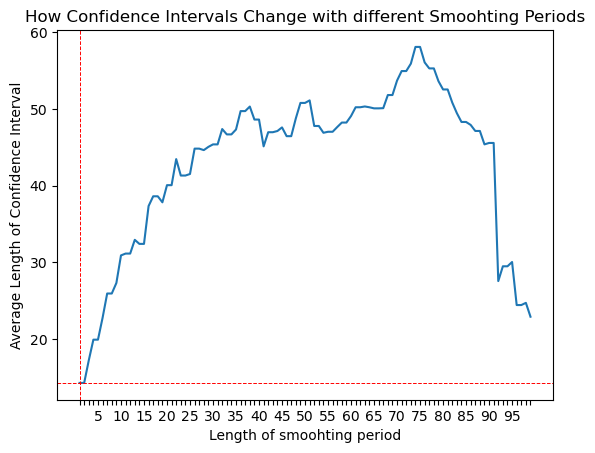

In [83]:
yconf_array = np.array(list(y_conf_width.values()))
yconf_min = np.min(yconf_array)
print('The minumum SMAPE is:', yconf_min)
length_min = list(y_conf_width.keys())[np.argmin(yconf_array)]
print('The length of smoothing period for the min SMAPE is:', length_min)
lengths = [length if int(length) % 5 == 0  else '' for length in y_conf_width.keys()]

plt.plot(y_conf_width.keys(), y_conf_width.values())
plt.xticks(range(0,99),lengths)
plt.axhline(y=yconf_min, color='r', linestyle='--', linewidth=0.7)
plt.axvline(x=length_min, color='r', linestyle='--', linewidth=0.7)
plt.ylabel('Average Length of Confidence Interval')
plt.xlabel('Length of smoohting period')
plt.title('How Confidence Intervals Change with different Smoohting Periods')
plt.show()